# Pipeline to Detect Lanes
---

## Calibrate Camera

This step needs to only be done once.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from lane_functions import chessboard_corners, find_reclanes, draw_box, find_window_centroids, window_mask

from IPython.display import Image, HTML, display
from glob import glob
%matplotlib inline

## Parameters and Cal Data

These include:
- Checkerboard dimensions
  + This took me an especially long time to debug. It turns out, I had
    miscounted the number of corners for each of the checkerboards.
    The count in the original lab example had (8,5). In contrast, the
    checkerboards here have (9,6) corners.
- Input file directory with images
  + This is found in `camera_cal/`.

In [2]:
# Parameters to find the chessboard corners. We have 9 columns and 6 rows, stored in "camera_cal"
checkcols = 9
checkrows = 6
imdir = 'camera_cal/'

# Find the object points and correspond with image points
objpoints, imgpoints = chessboard_corners( imdir, checkcols, checkrows )

# Visualize the images
imagesList=''.join( ["<img style='width: 150px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s) 
                 for s in sorted(glob('examples/calibration_output/*.jpg')) ])
display(HTML(imagesList))

Image: camera_cal/calibration2.jpg calibration successful
Image: camera_cal/calibration3.jpg calibration successful
Calibration Unsuccessful for camera_cal/calibration4.jpg
Calibration Unsuccessful for camera_cal/calibration5.jpg
Image: camera_cal/calibration6.jpg calibration successful
Image: camera_cal/calibration7.jpg calibration successful
Image: camera_cal/calibration8.jpg calibration successful
Image: camera_cal/calibration9.jpg calibration successful
Image: camera_cal/calibration10.jpg calibration successful
Image: camera_cal/calibration11.jpg calibration successful
Image: camera_cal/calibration12.jpg calibration successful
Image: camera_cal/calibration13.jpg calibration successful
Image: camera_cal/calibration14.jpg calibration successful
Image: camera_cal/calibration15.jpg calibration successful
Image: camera_cal/calibration16.jpg calibration successful
Image: camera_cal/calibration17.jpg calibration successful
Image: camera_cal/calibration18.jpg calibration successful
Image: 

## Find Parameters to Undistort

Make calls to calibrate the camera. The calibration and distortion parameters are stored in `mtx` and `dist`.

Length Objects: 17, Image Points: 17
Image Size: (1280, 720)


Text(0.5,1,'Undistorted Image')

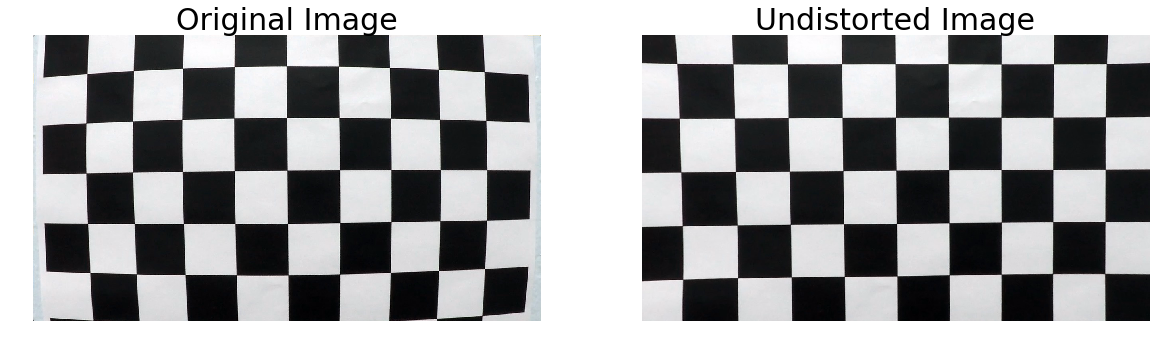

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
print('Length Objects: {}, Image Points: {}'.format(len(objpoints), len(imgpoints)))
print('Image Size: {}'.format(img_size))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10)); 
ax1.axis('off'); ax2.axis('off')
ax1.imshow(img); plt.imsave('examples/distorted.jpg',img); 
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst); plt.imsave('examples/undistorted.jpg', dst); 
ax2.set_title('Undistorted Image', fontsize=30)

## Reprojection Parameters (Perspective)

Warp the image to an overhead perspective

(-0.5, 1279.5, 719.5, -0.5)

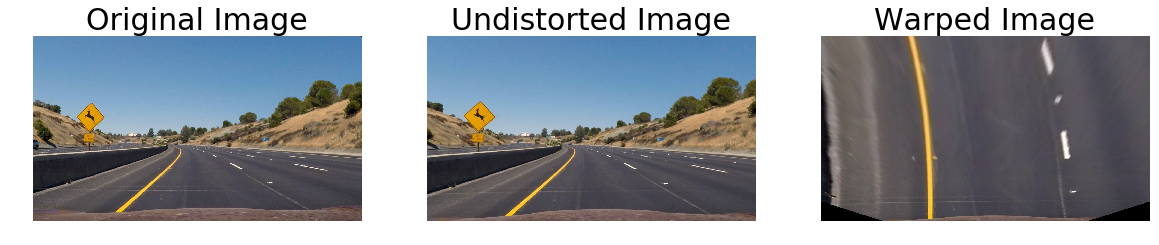

In [43]:
# Format is:
#    [ UpperLeft, LowerLeft, LowerRight, UpperRight ]
#    Assuming some symmetry, I added equal numbers left and right
src = np.float32(
     [[img_size[0] / 2 - 64, img_size[1] / 2 + 100],
      [img_size[0] / 6 - 10, img_size[1]],
      [img_size[0] * 5 / 6 + 10, img_size[1]],
      [img_size[0] / 2 + 64, img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4) + 50, 0],
     [(img_size[0] / 4) + 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, img_size[1]],
     [(img_size[0] * 3 / 4) - 50, 0]])

img = cv2.imread('test_images/test2.jpg')
# img = cv2.imread('test_images/straight_lines2.jpg')
calimg = cv2.undistort(img, mtx, dist, None, mtx)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(calimg, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30); ax1.axis('off')
ax2.imshow(cv2.cvtColor(calimg, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30); ax2.axis('off')
ax3.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax3.set_title('Warped Image', fontsize=30); ax3.axis('off')

## Draw lines on the image

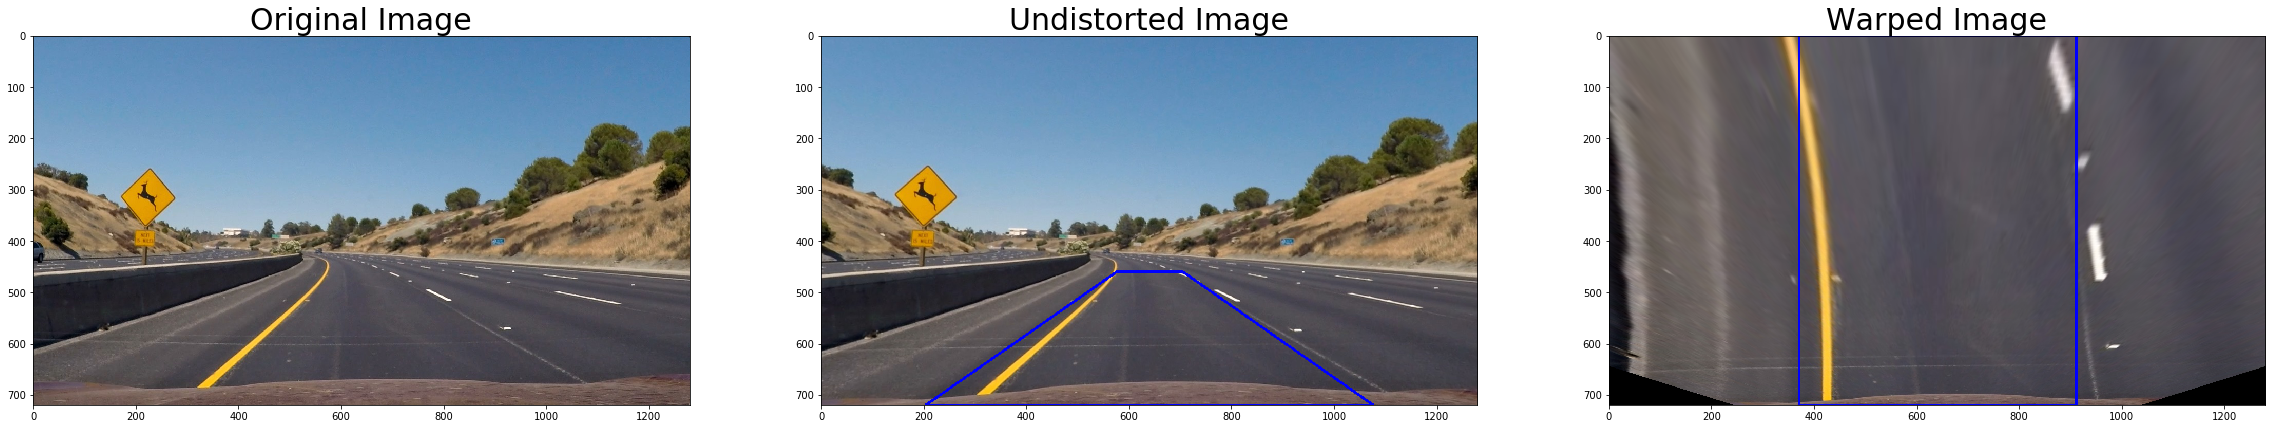

In [44]:
srcpairs = []; dstpairs = []
for pair in src:
    srcpairs += [tuple(pair.astype(int))]
for pair in dst:
    dstpairs += [tuple(pair.astype(int))]
    
fig = plt.figure(figsize=(40,40)); plt.axis('on'); fig.subplots(1,3)
ax1 = plt.subplot(1,3,1); ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30); 
ax2 = plt.subplot(1,3,2); draw_box(calimg, srcpairs)
ax2.set_title('Undistorted Image', fontsize=30); 
ax3 = plt.subplot(1,3,3); draw_box(warped, dstpairs)
ax3.set_title('Warped Image', fontsize=30); 

## Do some line detection from the overhead imagery

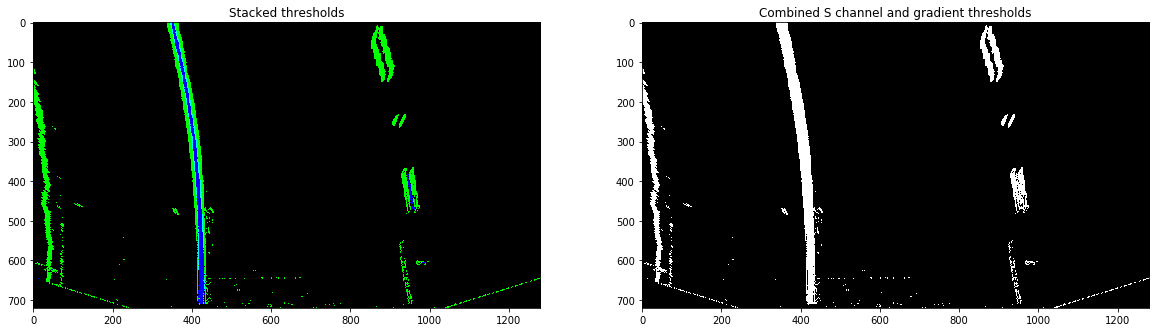

In [45]:
color_binary, combined_binary = find_reclanes(warped)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [46]:
def find_sliding_poly(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

left_fit, right_fit = find_sliding_poly(combined_binary)

(720, 0)

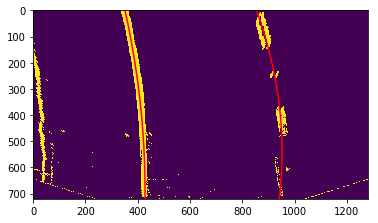

In [47]:
binary_warped = combined_binary

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
plt.imshow(binary_warped)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [48]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

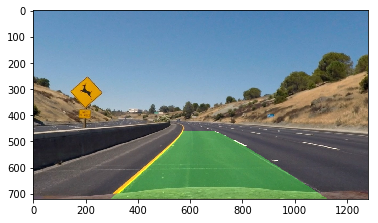

In [49]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)

# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
color_warp = np.copy(warp_zero)

# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(calimg, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

In [36]:
color_warp.shape

(720, 1280, 9)